In [1]:
import requests
import numpy as np
import pandas as pd
import pickle

In [2]:
import pathlib

import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2.1.0


In [3]:
NOAA_TOKEN = 'USqkpElQPhaSddqJHBEXKBQCyDSGLdZV'

EPA_EMAIL = 'ryla5068@colorado.edu'
EPA_KEY = 'russetgoose87'

In [4]:
class weather_data:
    def __init__(self, token, startdate, enddate):
        self.token = token
        self.startdate = startdate
        self.enddate = enddate
        
        print('Loading stations from pickle. This may take a minute...', end='')
        self._load_stations()
        if len(self.stations) == 0:
            print('Not found.')
        else:
            num_stations_loaded = sum([len(i) for _, i in self.stations.items()])
            print('Loaded {} stations.'.format(num_stations_loaded))
        
        self.datatypes = ['PRCP','WDFG','AWND','TAVG','TMAX','TMIN']
        
        for dtid in self.datatypes:
            num_stored = len(self.stations.get(dtid, []))
            _, num_available = self._get_stations(dtid, 0)
            
            print('For ' + dtid + ':\t{} stored,\t{} available'.format(num_stored, num_available))
            
            if num_stored == 0:
                self.stations[dtid] = []
            if num_stored < num_available:
                print('\tGetting stations. Starting with offset {}, going to {}\n\t'.format(num_stored, num_available), end='')
            
            
            offset = num_stored
            while offset < num_available:
                response_json, _ = self._get_stations(dtid, offset)

                for i in response_json['results']:
                    self.stations[dtid].append({'id': i['id'], 'latlon': np.array([i['latitude'], i['longitude']]) })
                
                self._dump_stations()
                
                print('.', end='')
                
                offset += 1000
            print('')
        
        num_stations_loaded = sum([len(i) for _, i in self.stations.items()])
        print('{} total stations and locations stored!'.format(num_stations_loaded))
        
    def _load_stations(self):
        try:
            self.stations = pickle.load( open('stations.pckl', 'rb') )
        except FileNotFoundError:
            self.stations = {}
            
    def _dump_stations(self):
        pickle.dump( self.stations, open('stations.pckl', 'wb') )
        
    def _get_stations(self, dtid, offset):
        payload = {'datasetid': 'GHCND', 'datatypeid': dtid, 'startdate': self.startdate, 'enddate': self.enddate, 'limit': '1000', 'offset': offset}
        head = {'token': self.token}
        response = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/stations', headers=head, params=payload)
        response_json = response.json()
        
        num_available = response_json['metadata']['resultset']['count']
        
        return response_json, num_available
    def get_nearest_station(self, dtid, lat, lon):
        target_loc = np.array([lat,lon])
        dists = []
        ids = []
        for i in self.stations[dtid]:
            dists.append( np.linalg.norm(i['latlon'] - target_loc) )
            ids.append(i['id'])

        val, idx = min((val, idx) for (idx, val) in enumerate(dists))
        return ids[idx]

    def get_nearest_weather(self, lat, lon, date_epa=None, date_noaa=None):
        if not date_epa and not date_noaa:
            raise AssertionError('Arguments date_epa and date_noaa cannot both be none.')
        if not date_noaa:
            date_noaa = date_epa[0:4] + '-' + date_epa[4:6] + '-' + date_epa[6:8]

        data = {}
        for dtid in self.datatypes:
        #for dtid in ['PRCP','WDFG','AWND','TAVG','TMAX','TMIN']:

            station_id = self.get_nearest_station(dtid, lat, lon)
            #station_id = get_nearest_station(self, dtid, lat, lon)


            payload = {'datasetid': 'GHCND', 'datatypeid': dtid, 'stationid': station_id, 'startdate': date_noaa, 'enddate': date_noaa}
            head = {'token': self.token}
            r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data', headers=head, params=payload)
            rj = r.json()

            try:
                for i in rj['results']:
                    datatype = i['datatype']
                    data[datatype] = i['value']
            except KeyError:
                pass


        return data

In [5]:
wd = weather_data(NOAA_TOKEN, '2017-01-10', '2019-12-30')

Loading stations from pickle. This may take a minute...Loaded 89119 stations.
For PRCP:	43143 stored,	43142 available

For WDFG:	750 stored,	750 available

For AWND:	1059 stored,	1058 available

For TAVG:	14742 stored,	14741 available

For TMAX:	14699 stored,	14698 available

For TMIN:	14726 stored,	14725 available

89119 total stations and locations stored!


In [6]:
class pollution_data:
    def __init__(self, email, key, verbose=False):
        self.email = email
        self.key = key
        
        # Get codes and descriptions for pollution data
        payload = {'email': self.email, 'key': self.key, 'pc': 'IMPROVE CARBON'}
        r = requests.get('https://aqs.epa.gov/data/api/list/parametersByClass', params=payload)
        
        if verbose:
            print('Request made for IMPROVE CARBON codes and descriptions:')
            print('URL:', r.url)
            print('RESPONSE:', r, '\n\n')
        
        jr = r.json()
        self.carbon_codes = []
        self.carbon_descs = []
        for i in jr['Data']:
            self.carbon_codes.append(i['code'])
            self.carbon_descs.append(i['value_represented'])
        
        if verbose:
            print('Got IMPROVE CARBON codes and descriptions:')
            for i in zip(self.carbon_codes, self.carbon_descs):
                print(i)
            print('\n')
            
        # Set Location Bounds
        self.loc_bounds = {'minlat': '27', 'maxlat': '50', 'minlon': '-130', 'maxlon': '-61'}
        if verbose:
            print('Created Location Bounds:', self.loc_bounds, '\n\n')
        
        # Create DataFrame
        self.DF = pd.DataFrame(columns=['date'])
        if verbose:
            print('Created Dataframe.')
            
    def load_poll(self, verbose=False):
        if verbose:
            print('Loading pollution data from pickle...', end='')
        try:
            self.DF = pickle.load( open('poll.pckl', 'rb') )
        except FileNotFoundError:
            if verbose:
                print('Pickle file not found. Use fetch_poll before using load_poll.')
        else:
            if verbose:
                print('Done.')
            
            
    def dump_poll(self):
        pickle.dump( self.DF, open('poll.pckl', 'wb') )
        
    def fetch_poll(self, bdate, edate, verbose=False):
        #for date in dates:
        for param, desc in zip(self.carbon_codes, self.carbon_descs):
            payload = {'email': self.email, 'key': self.key, 'param': param, 'bdate': bdate, 'edate': edate, 'minlat': self.loc_bounds['minlat'], 'maxlat': self.loc_bounds['maxlat'], 'minlon': self.loc_bounds['minlon'], 'maxlon': self.loc_bounds['maxlon']}
            r = requests.get('https://aqs.epa.gov/data/api/dailyData/byBox', params=payload)

            if verbose:
                print('Request made for {} with code {}:'.format(desc, param))
                #print('\tURL:', r.url)
                print('\tRESPONSE:', r)

            data = r.json()['Data']
            columns = []
            for i in data:
                columns.append({'date': i['date_local'], 'site_number': i['site_number'], 'lat': i['latitude'], 'lon': i['longitude'], desc: i['arithmetic_mean']})
            
            if len(columns) > 0:
                self.DF = self.DF.append(columns[0], ignore_index=True)
                self.DF = self.DF.append(columns, ignore_index=True)
            elif verbose:
                print('\t> No Rows Added')

        self.DF = self.DF.groupby(['site_number', 'date']).max()
        self.dump_poll()
        print('Dumped Data')
        
    def load_weather(self, verbose=False):
        if verbose:
            print('Loading weather data from pickle...', end='')
        try:
            self.DF = pickle.load( open('weather.pckl', 'rb') )
        except FileNotFoundError:
            if verbose:
                print('Pickle file not found. Use fetch_weather before using load_weather.')
        else:
            if verbose:
                print('Done.')
            
    def dump_weather(self):
        pickle.dump( self.DF, open('weather.pckl', 'wb') )
        
    def fetch_weather(self, wd, verbose=False):
        if verbose:
            print('Fetching weather data. ', end='')
        
        i=1
        for index, row in self.DF.iterrows():
            site_number = index[0]
            date = index[1]
            lat = row.lat
            lon = row.lon

            weather = wd.get_nearest_weather(lat, lon, date_noaa=date)

            for datatype, value in weather.items():
                self.DF.loc[index, datatype] = value
            
            if i%20 == 0:
                self.dump_weather()
                if verbose:
                    print('dumped', end='')
            if verbose:
                print('.', end='')
            i += 1
            

        print('\nDone.')
        
    def clean_data(self):
        self.DF = self.DF.fillna(self.DF.mean())
        
    def get_train_test(self):
        
        # Randomly split 20% of data for validation, but keep datapoints from same station in same dataset.
        sites = np.unique([index[0] for index, _ in self.DF.iterrows()])
        sites = np.random.permutation(sites)
        split_sites = [[],[],[],[],[]]
        for i in range(len(sites)):
            s = i%len(split_sites)
            split_sites[s].append(sites[i])
        splits = []
        for i in split_sites:
            splits.append(poll_data.DF.loc[i])
        take = 1
        train_df = None
        test_df = None
        for i in range(len(splits)):
            if i == take:
                test_df = splits[i]
            else:
                train_df = pd.concat([train_df, splits[i]])
                
                
        # Move date data from index to column
        train_df.reset_index(drop=False, inplace=True)
        test_df.reset_index(drop=False, inplace=True)

        
        # Convert date data to float
        epoch = pd.Timestamp('2014-01-01')

        train_dt = pd.to_datetime(train_df.date, yearfirst=True)
        train_df.loc[:,'date'] = (train_dt-epoch).astype('timedelta64[h]')

        test_dt = pd.to_datetime(test_df.date, yearfirst=True)
        test_df.loc[:,'date'] = (test_dt-epoch).astype('timedelta64[h]')

        
        # Split into x and y
        y_cols =  ['OC PM2.5 LC TOR', 'EC PM2.5 LC TOR', 'OC1 PM2.5 LC',
       'OC2 PM2.5 LC', 'OC3 PM2.5 LC', 'OC4 PM2.5 LC', 'OP PM2.5 LC TOR',
       'EC1 PM2.5 LC', 'EC2 PM2.5 LC', 'EC3 PM2.5 LC']

        train_x = train_df.drop(y_cols, 'columns')
        train_x = train_x.drop('site_number', 'columns')
        train_y = train_df[y_cols]

        test_x = test_df.drop(y_cols, 'columns')
        test_x = test_x.drop('site_number', 'columns')
        test_y = test_df[y_cols]

        # Norm train data
        x_mean = train_x.mean()
        x_std = train_x.std()
        train_x = (train_x - x_mean) / x_std
        test_x = (test_x - x_mean) / x_std
        
        self.X_train = train_x.values
        self.y_train = train_y.values
        self.X_test = test_x.values
        self.y_test = test_y.values
        
        return self.X_train, self.y_train, self.X_test, self.y_test


In [7]:
poll_data = pollution_data(EPA_EMAIL, EPA_KEY, verbose=True)

Request made for IMPROVE CARBON codes and descriptions:
URL: https://aqs.epa.gov/data/api/list/parametersByClass?email=ryla5068%40colorado.edu&key=russetgoose87&pc=IMPROVE+CARBON
RESPONSE: <Response [200]> 


Got IMPROVE CARBON codes and descriptions:
('88320', 'OC PM2.5 LC TOR')
('88321', 'EC PM2.5 LC TOR')
('88322', 'OCH PM2.5 LC TOT')
('88323', 'EH IMPROVE PM2.5 LC')
('88324', 'OC1 PM2.5 LC')
('88325', 'OC2 PM2.5 LC')
('88326', 'OC3 PM2.5 LC')
('88327', 'OC4 PM2.5 LC')
('88328', 'OP PM2.5 LC TOR')
('88329', 'EC1 PM2.5 LC')
('88330', 'EC2 PM2.5 LC')
('88331', 'EC3 PM2.5 LC')


Created Location Bounds: {'minlat': '27', 'maxlat': '50', 'minlon': '-130', 'maxlon': '-61'} 


Created Dataframe.


In [8]:
#poll_data.fetch_poll(bdate='20190118', edate='20190129', verbose=True)
#poll_data.fetch_poll(bdate='20190118', edate='20190118', verbose=True)
poll_data.load_poll(verbose=True)
#poll_data.fetch_weather(wd, verbose=True)
poll_data.load_weather(verbose=True)

Loading pollution data from pickle...Done.
Loading weather data from pickle...Done.


In [9]:
poll_data.DF.head()

OC PM2.5 LC TOR        lat        lon  \
site_number date                                                
0001        2019-01-18            1.590  46.288877 -70.785225   
            2019-01-21            1.560  46.288877 -70.785225   
            2019-01-24            1.801  46.288877 -70.785225   
            2019-01-27            3.730  46.288877 -70.785225   
0002        2019-01-18            2.769  45.079864 -79.012000   

                        EC PM2.5 LC TOR  OC1 PM2.5 LC  OC2 PM2.5 LC  \
site_number date                                                      
0001        2019-01-18            0.769         0.093         0.462   
            2019-01-21            0.571         0.120         0.415   
            2019-01-24            0.600         0.103         0.526   
            2019-01-27            1.150         0.452         0.708   
0002        2019-01-18            1.130         0.135         0.954   

                        OC3 PM2.5 LC  OC4 PM2.5 LC  OP PM2.5 LC TOR  \
site_number date                                                      
0001        2019-01-18         0.532         0.450            0.459   
            2019-01-21         0.473         0.603            0.380   
            2019-01-24         0.427         0.501            0.592   
            2019-01-27         0.970         1.117            0.711   
0002        2019-01-18         0.876         0.710            0.842   

                        EC1 PM2.5 LC  EC2 PM2.5 LC  EC3 PM2.5 LC   PRCP  WDFG  \
site_number date                                                                
0001        2019-01-18         0.983         0.240         0.007   14.0  33.0   
            2019-01-21         0.870         0.161         0.010   27.0  32.0   
            2019-01-24         0.934         0.172         0.008  227.0  26.0   
            2019-01-27         1.605         0.188         0.009   17.0  16.0   
0002        2019-01-18         1.715         0.183         0.009    7.0  27.0   

                        AWND   TAVG   TMAX   TMIN  
site_number date                                   
0001        2019-01-18  37.0 -134.0  -41.0 -228.0  
            2019-01-21  82.0 -174.0 -149.0 -199.0  
            2019-01-24  43.0   -3.0   34.0  -40.0  
            2019-01-27  46.0 -140.0  -23.0 -257.0  
0002        2019-01-18  39.0 -124.0  -47.0 -201.0

In [10]:
poll_data.clean_data()
X_train, y_train, X_test, y_test = poll_data.get_train_test()

/Users/marty/anaconda3/envs/ml/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
y_train.shape

(273, 10)

In [12]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[9]),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 5,450
Trainable params: 5,450
Non-trainable params: 0
_________________________________________________________________


In [14]:
EPOCHS = 1000

history = model.fit(
  X_train, y_train, epochs=EPOCHS, validation_data = (X_test, y_test), verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.6817,  mae:0.4962,  mse:0.6817,  val_loss:0.5247,  val_mae:0.4223,  val_mse:0.5247,  
....................................................................................................
Epoch: 100, loss:0.1104,  mae:0.1835,  mse:0.1104,  val_loss:0.3385,  val_mae:0.2998,  val_mse:0.3385,  
....................................................................................................
Epoch: 200, loss:0.0472,  mae:0.1258,  mse:0.0472,  val_loss:0.3944,  val_mae:0.3186,  val_mse:0.3944,  
....................................................................................................
Epoch: 300, loss:0.0265,  mae:0.0982,  mse:0.0265,  val_loss:0.4310,  val_mae:0.3275,  val_mse:0.4310,  
....................................................................................................
Epoch: 400, loss:0.0216,  mae:0.0877,  mse:0.0216,  val_loss:0.4604,  val_mae:0.3339,  val_mse:0.4604,  
........................................................................

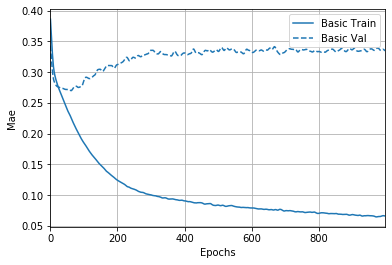

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
#plt.ylim([0, 10])
#plt.ylabel('MAE [MPG]')



In [18]:
y_cols =  ['OC PM2.5 LC TOR', 'EC PM2.5 LC TOR', 'OC1 PM2.5 LC',
       'OC2 PM2.5 LC', 'OC3 PM2.5 LC', 'OC4 PM2.5 LC', 'OP PM2.5 LC TOR',
       'EC1 PM2.5 LC', 'EC2 PM2.5 LC', 'EC3 PM2.5 LC']
poll_data.DF.loc[:,y_cols].mean()

OC PM2.5 LC TOR    1.612368
EC PM2.5 LC TOR    0.727494
OC1 PM2.5 LC       0.130383
OC2 PM2.5 LC       0.503599
OC3 PM2.5 LC       0.500213
OC4 PM2.5 LC       0.197170
OP PM2.5 LC TOR    0.348827
EC1 PM2.5 LC       0.900032
EC2 PM2.5 LC       0.155892
EC3 PM2.5 LC       0.011120
dtype: float64

In [19]:
poll_data.DF.loc[:,y_cols].std()

OC PM2.5 LC TOR    1.404874
EC PM2.5 LC TOR    0.659884
OC1 PM2.5 LC       0.205270
OC2 PM2.5 LC       0.473547
OC3 PM2.5 LC       0.494263
OC4 PM2.5 LC       0.200062
OP PM2.5 LC TOR    0.284019
EC1 PM2.5 LC       0.800468
EC2 PM2.5 LC       0.089053
EC3 PM2.5 LC       0.022655
dtype: float64